for finding the best parameters grid search has been applied and the model has been trained on kaggle since collab only offers 4 hours free acess of gpu.  for hyperparameter tuning the model is run for 2 -3 epoch with different learning rate ,batch size and optimizer with regularization constants ,after hyperparameter tuning the best lr comes out for which model generalizes well and have a desent em score is 2e-7 and the decay of 0.01 and the optimizer used is adamw and the batch size is 8.


fine tuning the spanbert model


Using device: cuda


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-3-a91f926569d7>:168: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Exact Match
1,5.273000,5.131239,47.805946
2,5.000500,4.812249,47.713299
3,4.797600,4.505995,47.881749
4,4.608000,4.319988,47.831214
5,4.507400,4.223758,47.999663
6,4.461400,4.182481,47.848059


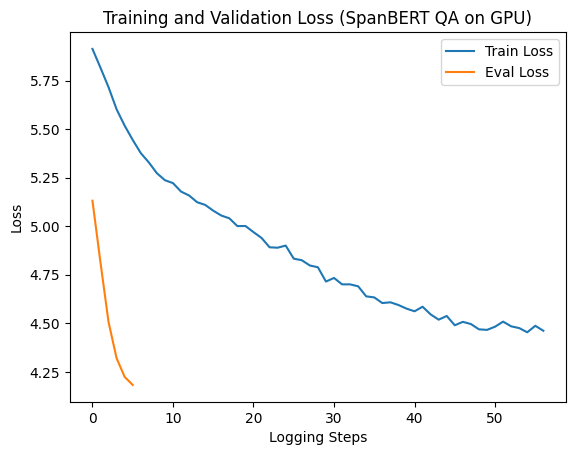

In [ ]:
# Install required packages (ensure you have transformers and datasets)
!pip install transformers datasets -q

import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# For evaluation: Exact Match Metric
def exact_match_score(predictions, references):
    assert len(predictions) == len(references), "Lists must have the same length"
    matches = sum(p.lower() == r.lower() for p, r in zip(predictions, references))
    return matches / len(references) * 100  # percentage

# Loading the SQuAD v2 dataset and select 15,000 training examples.
dataset = load_dataset("squad_v2")
train_dataset = dataset["train"].shuffle(seed=42).select(range(15000))
validation_dataset = dataset["validation"]

# 2. Fine-tuning the Baseline SpanBERT for Question Answering
MODEL_NAME = "SpanBERT/spanbert-base-cased"
# Getting the tokenizer from the pretrained model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Set maximum sequence length and document stride.
max_length = 384
doc_stride = 128

# Modular preprocessing function
def preprocess_function(examples, tokenizer, max_length, doc_stride):
    # Step 1: Clean questions
    def clean_questions(questions):
        return [question.lstrip() for question in questions]

    # Step 2: Tokenize inputs
    def tokenize_inputs(questions, contexts):
        return tokenizer(
            questions,
            contexts,
            max_length=max_length,
            truncation="only_second",
            stride=doc_stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length",
        )

    # Step 3: Modify offset mapping to keep only context tokens
    def modify_offset_mapping(offset_mapping, sequence_ids):
        return [
            (0, 0) if seq_id != 1 else offset
            for seq_id, offset in zip(sequence_ids, offset_mapping)
        ]

    # Step 4: Find start and end positions of the answer in the tokenized input
    def find_answer_positions(offset_mapping, sequence_ids, answer_text, answer_start):
        # Find the start of the context in the tokenized sequence
        start_idx = 0
        for idx,seq_id in enumerate(sequence_ids):
            if seq_id == 1:
                start_idx =idx
                break

        # Find the end of the context in the tokenized sequence
        end_idx = len(sequence_ids) - 1
        for idx in range(len(sequence_ids) - 1, -1, -1):
            if sequence_ids[idx]== 1:
                end_idx=idx
                break

        # Check if the answer is within the context span
        if not (offset_mapping[start_idx][0] <= answer_start and
                offset_mapping[end_idx][1] >=answer_start +len(answer_text)):
            return 0,0  # Answer is not in the context

        # Find the exact start token position
        for idx in range(start_idx,len(offset_mapping)):
            if offset_mapping[idx][0] >answer_start:
                start_idx = idx - 1
                break

        # Find the exact end token position
        token_end=start_idx
        for idx in range(start_idx,len(offset_mapping)):
            if offset_mapping[idx][1] >=answer_start + len(answer_text):
                token_end=idx
                break

        return start_idx,token_end

    # Step 5: Process a single example
    def process_example(example_id, answer, offset_mapping, sequence_ids):
        if len(answer["text"]) == 0:
            return example_id, 0, 0  # No answer

        answer_text=answer["text"][0]
        answer_start=answer["answer_start"][0]
        start_pos,end_pos=find_answer_positions(offset_mapping,sequence_ids,answer_text,answer_start)
        return example_id,start_pos,end_pos

    # Step 6: Main preprocessing logic
    def preprocess_data(examples):
        # Clean questions
        cleaned_questions=clean_questions(examples["question"])

        # Tokenize inputs
        tokenized_inputs=tokenize_inputs(cleaned_questions,examples["context"])

        # Extract sample mapping and offset mapping
        samp_mapping=tokenized_inputs.pop("overflow_to_sample_mapping")
        offset_mapping=tokenized_inputs.pop("offset_mapping")

        # Initialize lists for example IDs, start positions, and end positions
        example_ids=[]
        start_positions=[]
        end_positions=[]

        # Process each tokenized input
        for idx,offsets in enumerate(offset_mapping):
            samp_idx = samp_mapping[idx]
            example_id=examples["id"][samp_idx]
            sequence_ids=tokenized_inputs.sequence_ids(idx)

            # Modify offset mapping to keep only context tokens
            offset_mapping[idx]=modify_offset_mapping(offsets,sequence_ids)

            # Process the example
            answer=examples["answers"][samp_idx]
            example_id,start_pos,end_pos=process_example(example_id,answer,offset_mapping[idx],sequence_ids)
            example_ids.append(example_id)
            start_positions.append(start_pos)
            end_positions.append(end_pos)

        # Add processed data to tokenized inputs
        tokenized_inputs["example_id"]=example_ids
        tokenized_inputs["start_positions"]=start_positions
        tokenized_inputs["end_positions"]=end_positions

        return tokenized_inputs

    # Execute the preprocessing


    # Execute the preprocessing
    return preprocess_data(examples)

# Tokenize the training and validation sets.
tokenized_train = train_dataset.map(
    lambda x: preprocess_function(x, tokenizer, max_length, doc_stride),
    batched=True,
    remove_columns=train_dataset.column_names,
)
tokenized_valid = validation_dataset.map(
    lambda x: preprocess_function(x, tokenizer, max_length, doc_stride),
    batched=True,
    remove_columns=validation_dataset.column_names,
)

# Optionally set format to "torch" for faster data access.
tokenized_train.set_format("torch")
tokenized_valid.set_format("torch")

# =============================================================================
# 3. Training Configuration (Optimized for GPU)
# =============================================================================
training_args = TrainingArguments(
    output_dir="./spanbert_qa_gpu",
    evaluation_strategy="epoch",
    learning_rate=2e-7,
    num_train_epochs=6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    logging_steps=200,
    save_strategy="epoch",

    fp16=True,
)

# Load the baseline QA model.
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME).to(device)

# Simple post-processing to decode predictions refered from hugging face .
def postprocess_qa_predictions(examples, features, raw_predictions):
    total_start_logits, total_end_logits = raw_predictions
    predictions = {}
    for i, example in enumerate(examples):
        feature = features[i]
        input_ids = feature["input_ids"]
        start_logits = total_start_logits[i]
        end_logits = total_end_logits[i]
        best_start = int(np.argmax(start_logits))
        best_end = int(np.argmax(end_logits))
        if best_start > best_end:
            predic = ""
        else:
            predic = tokenizer.decode(input_ids[best_start:best_end + 1], skip_special_tokens=True)
        predictions[example["id"]] = predic
    return predictions

def compute_metrics(p):

    predictions = postprocess_qa_predictions(validation_dataset, tokenized_valid, p.predictions)

    # Create references dictionary
    references = {}
    for ex in validation_dataset:
        references[ex["id"]] = ex["answers"]["text"][0] if ex["answers"]["text"] else ""

    # Collect predictions and references
    preds = []
    refs = []
    for key in references.keys():
        preds.append(predictions[key])
        refs.append(references[key])

    # Compute exact match score
    score = exact_match_score(preds, refs)

    return {"exact_match": score}


# 4. Create Trainer and Start Training

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Start fine-tuning on GPU.
trainer.train()


# 5. Ploting Training and Validation Loss

log_history = trainer.state.log_history
train_losses = [log["loss"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(eval_losses, label="Eval Loss")
plt.xlabel("Logging Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss (SpanBERT QA on GPU)")
plt.show()

Epochs: [1, 2, 3, 4, 5, 6]
Training Loss: [5.273, 5.0005, 4.7976, 4.608, 4.5074, 4.4614]
Validation Loss: [5.131239414215088, 4.812249183654785, 4.50599479675293, 4.319987773895264, 4.223758220672607, 4.182480812072754]


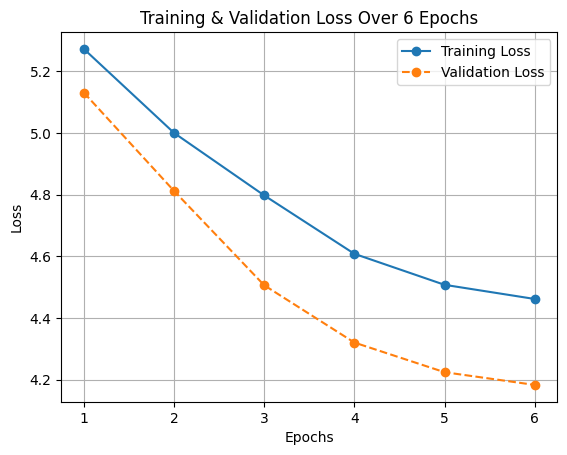

In [ ]:
import matplotlib.pyplot as plt

# Extract logged losses
logs=trainer.state.log_history

# Extract training and validation loss at the end of each epoch
training_loss_per_epoch= []
evaluation_loss_per_epoch= []
epochs= []

for log in logs:
    if "epoch" in log:
        epoch = int(log["epoch"])

        # Capture validation loss (always logged once per epoch)
        if "eval_loss" in log:
            evaluation_loss_per_epoch.append(log["eval_loss"])
            epochs.append(epoch)

        # Capture last training loss of each epoch
        if "loss" in log:
            last_train_loss = log["loss"]

    # Append the last logged training loss for the epoch
    if epoch not in training_loss_per_epoch and "eval_loss" in log:
        training_loss_per_epoch.append(last_train_loss)

# Ensure both lists have the same length
training_loss_per_epoch = training_loss_per_epoch[:len(evaluation_loss_per_epoch)]

# Debugging prints
print(f"Epochs: {epochs}")
print(f"Training Loss: {training_loss_per_epoch}")
print(f"Validation Loss: {evaluation_loss_per_epoch}")

# Plot Training Loss
plt.plot(epochs, training_loss_per_epoch, label="Training Loss", marker="o", linestyle="-")

# Plot Validation Loss
plt.plot(epochs, evaluation_loss_per_epoch, label="Validation Loss", marker="o", linestyle="--")

# Labels & Title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over 6 Epochs")
plt.legend()
plt.grid(True)
plt.show()

fine tuning the spanbert with crf layer on top


In [2]:
!pip install transformers datasets torch pytorch-crf accelerate -q
#importing the modules
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchcrf import CRF
from transformers import (AutoModelForQuestionAnswering,AutoTokenizer,AdamW,get_scheduler)
from accelerate import Accelerator
import numpy as np
from tqdm import tqdm


# Enabling the mixed precision for fast running on gpu
accelerator=Accelerator(mixed_precision="fp16")

# Exact match metric
def exact_match_score(predictions,references):
    assert len(predictions)==len(references), "Lists must have the same length"
    matches=sum(p.lower()==r.lower() for p,r in zip(predictions, references))
    return matches/len(predictions)*100

# Load and preprocess dataset

def loading_data():

    data=load_dataset("squad_v2")

    training_data=data["train"].select(range(15000))

    validation_data=data["validation"]

    return training_data,validation_data

# BERT-based tokenizer

def load_tokenizer():
    return AutoTokenizer.from_pretrained("SpanBERT/spanbert-base-cased")


# Tokenize examples

def tokenized_examp(exmp,tokenizer):
    tokenized_example=tokenizer(
        exmp["question"],
        exmp["context"],
        truncation="only_second",
        max_length=384,
        stride=128,
        padding="max_length",
        return_overflowing_tokens=True,
        return_offsets_mapping=True,

      )


    return tokenized_example


# Process tokenized examples
def processing_tokenized_examples(tokenized_data_examples,examples_data,tokenizer):
    # making keys in tghe dictionary for storing the stating positions and the ending position and labels for crf .
    tokenized_data_examples["start_positions"]=[]
    tokenized_data_examples["end_positions"]=[]
    tokenized_data_examples["crf_labels"]=[]

    offsetmap=tokenized_data_examples.pop("offset_mapping")

    samplemap=tokenized_data_examples.pop("overflow_to_sample_mapping")

    #proceesing one element at a time

    for i, j in enumerate(offsetmap):
        processing_one_example(tokenized_data_examples, i, j, samplemap, examples_data, tokenizer)

    return tokenized_data_examples


def check(answer):
  if answer["text"]:
    return 1
  else:
    return 0


# Process a single example
def processing_one_example(tokenized_data_samples, index, offsets, sample_mapping, examples, tokenizer):

    input_ids=tokenized_data_samples["input_ids"][index]
    cls_index=input_ids.index(tokenizer.cls_token_id)
    starting_pos=cls_index
    ending_pos=cls_index
    sequence_ids=tokenized_data_samples.sequence_ids(index)
    sample_index=sample_mapping[index]
    answers=examples["answers"][sample_index]


    labels = [2] * len(offsets)

    if check(answers):
        starting_pos,ending_pos,labels=update_positions_and_labels(answers,offsets,sequence_ids,starting_pos,ending_pos,labels)

    tokenized_data_samples["start_positions"].append(starting_pos)
    tokenized_data_samples["end_positions"].append(ending_pos)
    tokenized_data_samples["crf_labels"].append(labels)


# Update positions and labels
def update_positions_and_labels(answers, offsets, sequence_ids, start_position, end_position, labels):
    starting_char=answers["answer_start"][0]
    s=len(answers["text"][0])
    ending_char=starting_char+s

    token_s_ind,token_e_ind=find_indices(sequence_ids,offsets,starting_char,ending_char)

    if token_s_ind is not None and token_e_ind is not None:
        start_position = max(0, token_s_ind - 1)
        end_position = min(len(offsets) - 1, token_e_ind + 1)
        labels=update_crf_labels(labels, start_position, end_position)

    return start_position,end_position,labels

# Find token indices for the answer span
def find_indices(sequence_ids, offsets, startchar, endchar):
    token_start_index = None
    token_end_index = None

    # Find the first valid token in sequence
    for i in range(len(sequence_ids)):
        if sequence_ids[i] == 1:
            token_start_index = i
            break

    # Find the last valid token in sequence
    for i in range(len(sequence_ids) - 1, -1, -1):
        if sequence_ids[i] == 1:
            token_end_index = i
            break

    # Ensure the character indices fall within the found tokens
    if token_start_index is not None and token_end_index is not None:
        if offsets[token_start_index][0] <= startchar and offsets[token_end_index][1] >= endchar:
            # Adjust start index
            for i in range(token_start_index, len(offsets)):
                if offsets[i][0] > startchar:
                    token_start_index = i - 1
                    break

            # Adjust end index
            for i in range(token_end_index, -1, -1):
                if offsets[i][1] >= endchar:
                    token_end_index = i
                    break


            return token_start_index, token_end_index

    return None, None


# Update CRF labels for the answer span
def update_crf_labels(labels, start_pos, end_pos):
    labels[start_pos] = 0  # B tag
    for j in range(start_pos + 1, end_pos):
        labels[j] = 1  # I tag
    return labels

# Prepare datasets
def prepareing_datasets(train_dataset, val_dataset, tokenizer):
    train_tokenized_ques_ans = train_dataset.map(lambda x: tokenized_examp(x, tokenizer), batched=True, remove_columns=train_dataset.column_names, num_proc=4)
    val_tokenized_ques_ans = val_dataset.map(lambda x: tokenized_examp(x, tokenizer), batched=True, remove_columns=val_dataset.column_names, num_proc=4)
    return train_tokenized_ques_ans, val_tokenized_ques_ans

# Collate function
def collating_fun(batch):
    collated_batch = {
        "input_ids": torch.stack([torch.tensor(item["input_ids"]) for item in batch]),
        "attention_mask": torch.stack([torch.tensor(item["attention_mask"]) for item in batch]),
        "start_positions": torch.tensor([item.get("start_positions", 0) for item in batch]),
        "end_positions": torch.tensor([item.get("end_positions", 0) for item in batch]),
        "crf_labels": torch.stack([torch.tensor(item.get("crf_labels", [2] * 384)) for item in batch]),
    }
    return collated_batch




# SpanBERT + CRF model
class SpanBERTCRF(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.spanbert = AutoModelForQuestionAnswering.from_pretrained("SpanBERT/spanbert-base-cased")
        self.projection = torch.nn.Linear(self.spanbert.config.hidden_size, 3)  # 3 classes: B, I, O
        self.crf = CRF(3, batch_first=True)

    def forward(self, input_ids, attention_mask, start_positions=None, end_positions=None, crf_labels=None):
        outputs = self.spanbert(input_ids=input_ids,attention_mask=attention_mask,start_positions=start_positions,end_positions=end_positions,output_hidden_states=True)
        hidden_states = outputs.hidden_states[-1]
        emis = self.projection(hidden_states)
        spanbertloss = outputs.loss

        crf_loss = None
        if crf_labels is not None:
            crf_loss = -self.crf(emis, crf_labels, mask=attention_mask.bool(), reduction='mean')

        total_loss= spanbertloss + 0.1 * crf_loss if crf_loss is not None else spanbertloss


        output_dict = {"loss": total_loss,"start_logits": outputs.start_logits,"end_logits": outputs.end_logits,"crf_tags": self.crf.decode(emis, mask=attention_mask.bool())}

        return output_dict



# Training function
def train_spanbert_crf(model, train_loader, val_loader, optimizer, accelerator,tokenizer):
    t_loss=[]
    v_loss=[]
    for epoch in range(6):  # Train for 6 epochs
        model.train()
        total_training_loss=0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            outputs = model(input_ids=batch["input_ids"],attention_mask=batch["attention_mask"],start_positions=batch["start_positions"],end_positions=batch["end_positions"],crf_labels=batch["crf_labels"])
            accelerator.backward(outputs["loss"])
            optimizer.step()
            optimizer.zero_grad()
            total_training_loss += outputs["loss"].item()


        # Validation
        total_vali_loss=0
        model.eval()
        total_predictions = []
        total_references = []

        for batch in tqdm(val_loader, desc="Validation"):
            with torch.no_grad():
                outputs = model(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    start_positions=batch["start_positions"],
                    end_positions=batch["end_positions"],
                    crf_labels=batch["crf_labels"]
                )
                total_vali_loss+= outputs["loss"].item()

                start_of_preds = torch.argmax(outputs["start_logits"], dim=1)
                end_of_preds = torch.argmax(outputs["end_logits"], dim=1)

                for i in range(len(start_of_preds)):
                    input_ids = batch["input_ids"][i]
                    start_predic = start_of_preds[i].item()
                    end_predic = end_of_preds[i].item()
                    start_ref = batch["start_positions"][i].item()
                    end_ref = batch["end_positions"][i].item()

                    predicted_text = tokenizer.decode(input_ids[start_predic:end_predic+1], skip_special_tokens=True) if start_predic <= end_predic else ""
                    reference_text = tokenizer.decode(input_ids[start_ref:end_ref+1], skip_special_tokens=True)

                    total_predictions.append(predicted_text)
                    total_references.append(reference_text)

        train_loss=total_training_loss/len(train_loader)
        val_loss=total_vali_loss/len(val_loader)
        t_loss.append(train_loss)
        v_loss.append(val_loss)
        em_score=exact_match_score(total_predictions,total_references)

        print(f"Epoch {epoch+1}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | EM Score: {em_score:.2f}%")

    accelerator.save(model.state_dict(), "spanbert_crf_finetuned.pt")
    return t_loss,v_loss


#preprocessing and loading the data
train_dataset,val_dataset=loading_data()
tokenizer = load_tokenizer()
train_tokenized_qa,val_tokenized_qa=prepareing_datasets(train_dataset,val_dataset,tokenizer)
# initializing the crf model
model = SpanBERTCRF()
#defining the optimizer
optimizer = AdamW(model.parameters(), lr=1e-7)

train_loader = DataLoader(train_tokenized_qa, batch_size=8, shuffle=True, collate_fn=collating_fun)
val_loader = DataLoader(val_tokenized_qa, batch_size=8, collate_fn=collating_fun)

model,optimizer,train_loader,val_loader= accelerator.prepare(
    model,optimizer,train_loader,val_loader
)



Map (num_proc=4):   0%|          | 0/15000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/11873 [00:00<?, ? examples/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [5]:
print("\ntraining the model")

trn_loss,val_loss=train_spanbert_crf(model,train_loader,val_loader,optimizer,accelerator,tokenizer)

print("\nTraining complete!.")

training the model
Validation: 100%|██████████| 1538/1538 [06:21<00:00,  4.03it/s]
Epoch 1
Train Loss: 17.0643 | Val Loss: 11.3318 | EM Score: 49.05%
Validation: 100%|██████████| 1538/1538 [06:15<00:00,  4.10it/s]
Epoch 2
Train Loss: 9.4521 | Val Loss: 8.8681 | EM Score: 54.57%
Validation: 100%|██████████| 1538/1538 [06:17<00:00,  4.07it/s]
Epoch 3
Train Loss: 8.3085 | Val Loss: 8.1521 | EM Score: 59.08%
Validation: 100%|██████████| 1538/1538 [07:25<00:00,  3.45it/s]
Epoch 4
Train Loss: 7.8959 | Val Loss: 7.8336 | EM Score: 61.49%
Validation: 100%|██████████| 1538/1538 [06:27<00:00,  3.97it/s]
Epoch 5
Train Loss: 7.5123 | Val Loss: 7.2766 | EM Score: 65.17%
Validation: 100%|██████████| 1538/1538 [06:23<00:00,  4.01it/s]
Epoch 6
Train Loss: 6.7611 | Val Loss: 6.3127 | EM Score: 66.23%

Training complete!.



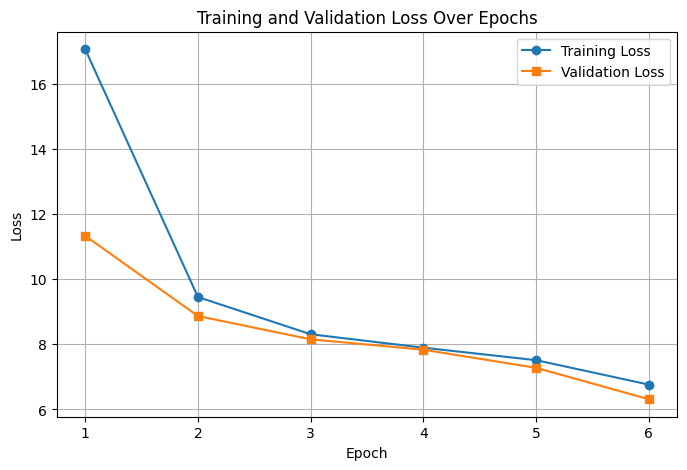

In [4]:
import matplotlib.pyplot as plt
# Plot the losses
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(trn_loss) + 1), trn_loss, label="Training Loss", marker="o")
plt.plot(range(1, len(val_loss) + 1), val_loss, label="Validation Loss", marker="s")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()
